In [ ]:
!pip install datasets accelerate bitsandbytes

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 25.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.1/69.1 MB 11.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 13.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 9.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 11.9 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [ ]:
from transformers import AutoModelForSequenceClassification, AutoTokenizer

In [ ]:
from datasets import load_dataset
dataset = load_dataset("OsBaran/try")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/358 [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/94.3M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/78588 [00:00<?, ? examples/s]

In [ ]:
model = AutoModelForSequenceClassification.from_pretrained("OsBaran/Bert-Classification-Model").to("cuda")
tokenizer = AutoTokenizer.from_pretrained("google-bert/bert-large-uncased")

config.json:   0%|          | 0.00/741 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.34G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

In [ ]:
data = dataset.shuffle().map(lambda x: tokenizer(x["text"],truncation=True))

Map:   0%|          | 0/78588 [00:00<?, ? examples/s]

In [ ]:
import transformers
trainer = transformers.Trainer(
    model=model,
    train_dataset=data["train"],
    args=transformers.TrainingArguments(
        per_device_train_batch_size=16,
        gradient_accumulation_steps=4,
        warmup_steps=100,
        num_train_epochs=5,
        learning_rate=2e-5,
        fp16=True,
        logging_steps=10,
        optim="adamw_torch",
        push_to_hub = True,
        save_steps=200,
        output_dir="Bert-Classification-Model",
  ),
    data_collator=transformers.DataCollatorWithPadding(tokenizer=tokenizer, return_tensors="pt")
)

In [ ]:
trainer.train()

KeyboardInterrupt: 

In [ ]:
len(data["train"][0]["input_ids"])

1024

In [ ]:
string = """Turkey is a country"""

In [ ]:
model(tokenizer.encode(string,truncation=True,return_tensors="pt").cuda())

SequenceClassifierOutput(loss=None, logits=tensor([[ 1.8934, -2.0694]], device='cuda:0', grad_fn=<AddmmBackward0>), hidden_states=None, attentions=None)

In [ ]:
from datasets import load_dataset
dataset = load_dataset("OsBaran/isot_news_dataset")

README.md:   0%|          | 0.00/313 [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/68.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/44898 [00:00<?, ? examples/s]

In [ ]:
tokenized_test = dataset['train'].map(
    lambda x: tokenizer(x['text'], padding="max_length", truncation=True),
    batched=True
)

Map:   0%|          | 0/44898 [00:00<?, ? examples/s]

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


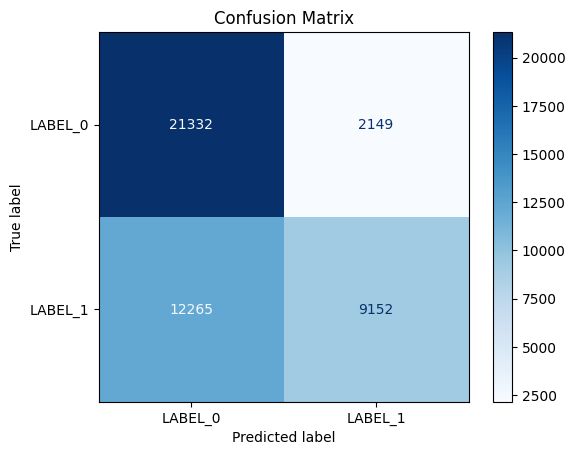

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import numpy as np
import matplotlib.pyplot as plt
predictions = trainer.predict(tokenized_test)
y_pred = np.argmax(predictions.predictions, axis=1)
y_true = predictions.label_ids

cm = confusion_matrix(y_true, y_pred)

# Çizim
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.config.id2label.values())
disp.plot(cmap="Blues")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, accuracy_score, precision_score, recall_score, f1_score
import numpy as np
import matplotlib.pyplot as plt
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average="weighted")
recall = recall_score(y_true, y_pred, average="weighted")
f1 = f1_score(y_true, y_pred, average="weighted")

print(f"Doğruluk: {accuracy:.4f}")
print(f"Kesinlik: {precision:.4f}")
print(f"Duyarlılık: {recall:.4f}")
print(f"F1 Skoru: {f1:.4f}")

Doğruluk: 0.6790
Kesinlik: 0.7184
Duyarlılık: 0.6790
F1 Skoru: 0.6578


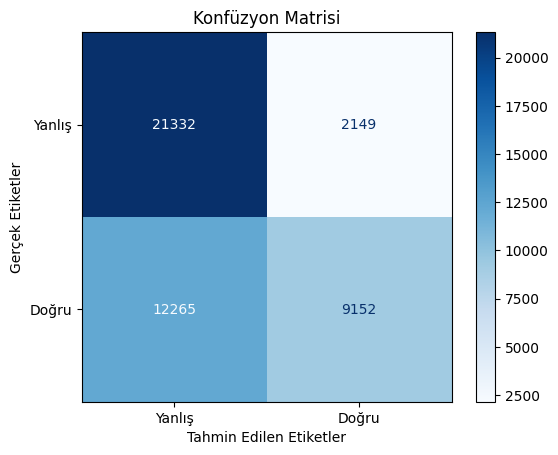

In [ ]:
cm = confusion_matrix(y_true, y_pred)


true_labels = ['Yanlış', 'Doğru']  
predicted_labels = ['Yanlış', 'Doğru']  


disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=predicted_labels)
disp.plot(cmap="Blues")


plt.xticks(ticks=np.arange(len(predicted_labels)), labels=predicted_labels)
plt.yticks(ticks=np.arange(len(true_labels)), labels=true_labels)
plt.title("Konfüzyon Matrisi")
plt.xlabel("Tahmin Edilen Etiketler")
plt.ylabel("Gerçek Etiketler")
plt.show()